In [1]:
import codecs, re, os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score

from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [11]:
def load_speaker(path="../data/raw/corpus.tache1.learn.utf8"):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)

X, y = load_speaker()
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
import joblib
d = joblib.load("../gridsearch/results/part1_hrscv_LogisticRegression_kappa.pkl")
d.best_params_

c:\Users\Valinquish\Anaconda\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Valinquish\Anaconda\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Valinquish\Anaconda\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. 

{'model__C': 0.007047693060992694,
 'model__class_weight': 'balanced',
 'model__fit_intercept': True,
 'model__max_iter': 1000,
 'model__penalty': 'l2',
 'tfidf__norm': None,
 'tfidf__smooth_idf': False,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'vect__binary': True,
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': None,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None,
 'vect__strip_accents': 'unicode'}

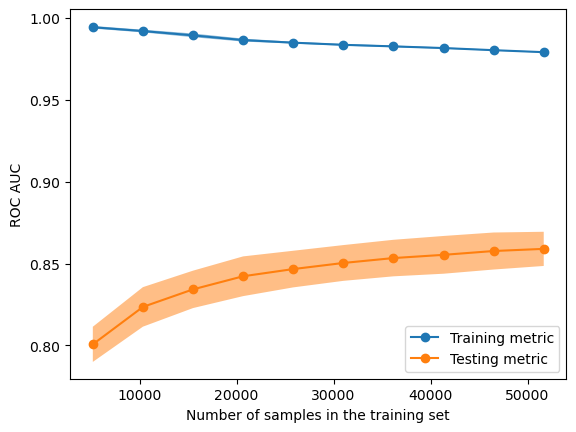

In [5]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

pipeline = d.best_estimator_

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 10,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "roc_auc",
    "score_name": "ROC AUC",
}


LearningCurveDisplay.from_estimator(pipeline, **common_params)


c:\Users\Valinquish\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Valinquish\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

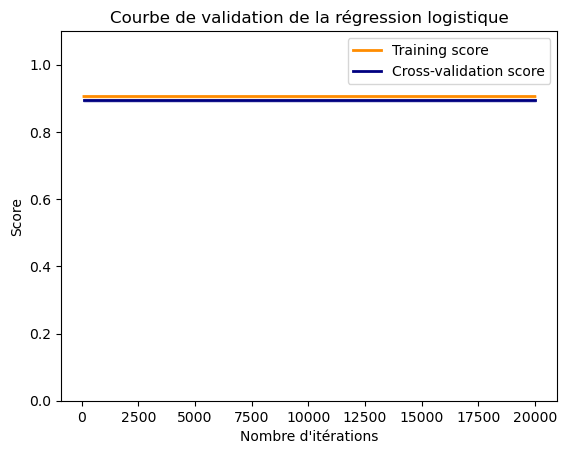

In [12]:
from sklearn.model_selection import validation_curve

pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("model", LogisticRegression()),
    ]
)

indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]

param_range = (100, 1000, 10000, 20000)

train_scores, test_scores = validation_curve(
    pipeline, X, y, param_name="model__max_iter", param_range=param_range, cv=5
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Courbe de validation de la régression logistique")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()
